In [1]:
import argparse
import os
import pickle
import shutil

import sklearn.metrics as metrics
import torch
from tensorboardX import SummaryWriter

import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain
import sys

In [2]:
from train import *

In [3]:
import pickle
import torch
from tensorboardX import SummaryWriter
import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain


# Step 1: Argument Parsing (based on your explainer_main.py setup)
def arg_parse():
    # Check if we are in a Jupyter notebook environment

    # Manually set the arguments for notebook usage
    class Args:
        dataset = "synthetic"
        bmname = "synthetic"
        pkl_fname = None
        logdir = "log"
        ckptdir = "ckpt"
        cuda = "0"
        gpu = False
        num_epochs = 1
        hidden_dim = 20
        test_ratio = 0.1
        output_dim = 20
        num_gc_layers = 3
        dropout = 0.01
        mask_act = "sigmoid"
        explain_node = None
        graph_idx = -1
        graph_mode = True  # Graph classification mode
        align_steps = 1000
        opt = "adam"
        opt_scheduler = "none"
        method = "base"  # Method attribute was missing
        name_suffix = ""
        explainer_suffix = ""
        clip = 2.0
        lr = 0.1
        batch_size = 20
        max_nodes = 100
        train_ratio = 0.8
        bias = True
        clean_log = False
        bn = False
        mask_bias = False
        num_workers = 1
        feature_type = "default"

    return Args()


prog_args = arg_parse()

synthetic_task(prog_args)


# Step 2: Function to Initialize Explainer and Model
def initialize_explainer():
    # Load the arguments

    if prog_args.gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = prog_args.cuda
        print("Using GPU")
    else:
        print("Using CPU")

    # Load a model checkpoint
    ckpt = io_utils.load_ckpt(prog_args)
    cg_dict = ckpt["cg"]  # get computation graph

    input_dim = cg_dict["feat"].shape[2]
    num_classes = cg_dict["pred"].shape[2]

    print("Loaded model from checkpoint")
    print("Input dim:", input_dim, "; Num classes:", num_classes)

    # Build the model
    if prog_args.graph_mode:
        model = models.GcnEncoderGraph(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )
    else:
        model = models.GcnEncoderNode(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )

    # Load the model state
    model.load_state_dict(ckpt["model_state"])

    # Initialize the explainer
    explainer = explain.Explainer(
        model=model,
        adj=cg_dict["adj"],
        feat=cg_dict["feat"],
        label=cg_dict["label"],
        pred=cg_dict["pred"],
        train_idx=cg_dict["train_idx"],
        args=prog_args,
        writer=None,  # No Tensorboard logging for simplicity
        print_training=True,
        graph_mode=prog_args.graph_mode,
        graph_idx=prog_args.graph_idx,
    )

    return explainer


# Step 3: Prototype Extraction Function
import torch
import numpy as np


# Function to extract prototype (non-masked nodes and features)
def extract_prototype(graph_idx, explainer):
    """
    Extract and save the prototype for a given graph.

    Args:
        graph_idx: Index of the graph to explain
        explainer: The explainer instance used to generate explanations

    Returns:
        prototype: A dictionary containing important nodes and their corresponding important features
    """
    print(f"Explaining graph {graph_idx}...")

    # Explain the graph and get the masked adjacency matrix
    masked_adj = explainer.explain(node_idx=0, graph_idx=graph_idx, graph_mode=True)

    # If masked_adj is a numpy array, convert it to a tensor
    if isinstance(masked_adj, np.ndarray):
        masked_adj = torch.tensor(masked_adj)

    # Get feature mask if available
    mask_feat = explainer.mask_feat if hasattr(explainer, "mask_feat") else None

    # Retain only the non-masked nodes (summing over axis 1 to get the importance of each node)
    node_importance = masked_adj.sum(dim=1)  # Sum over rows to get node importance
    important_nodes = torch.nonzero(
        node_importance > 0
    ).squeeze()  # Keep important nodes

    # Retain only non-masked features for important nodes
    important_features = explainer.feat[important_nodes]
    if mask_feat is not None:
        important_features = important_features * mask_feat[important_nodes]

    # Prepare the prototype data
    prototype = {
        "important_nodes": important_nodes.cpu().numpy(),
        "important_features": important_features.cpu().numpy(),
    }

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype


# Initialize the explainer
explainer = initialize_explainer()

# Step 4: Generate prototypes for test graphs (replace with your test graph indices)
test_graph_indices = [0, 1, 2, 3]  # Example test graph indices

# Extract prototypes
for graph_idx in test_graph_indices:
    prototype = extract_prototype(graph_idx, explainer)
    print(prototype)
    print(f"Prototype for graph {graph_idx}: {prototype}")

Number of classes: 360
3
Using node labels
Num training graphs:  288 ; Num validation graphs:  36 ; Num testing graphs:  36
Number of graphs:  360
Number of edges:  5940
Max, avg, std of graph size:  11 , 10.00 , 0.82
Method: base
Epoch:  0
Avg loss:  tensor(5.5323, grad_fn=<DivBackward0>) ; epoch time:  6.21387791633606
Train  accuracy: 0.25


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation  accuracy: 0.25


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test  accuracy: 0.25
Best val result:  {'epoch': 0, 'loss': tensor(5.5323, grad_fn=<DivBackward0>), 'acc': 0.25}
Test result:  {'prec': 0.0625, 'recall': 0.25, 'acc': 0.25, 'epoch': 0}
torch.Size([288, 100, 100]) torch.Size([288, 100, 4]) torch.Size([288])
Validation  accuracy: 0.25
Using CPU
loading model
ckpt/synthetic_base_h20_o20.pth.tar
=> loading checkpoint 'ckpt/synthetic_base_h20_o20.pth.tar'
Loaded model from checkpoint
Input dim: 4 ; Num classes: 360
Explaining graph 0...
Graph predicted label:  174
epoch:  0 ; loss:  42.91960525512695 ; mask density:  0.7122499346733093 ; pred:  tensor([0.0049, 0.0048, 0.0044, 0.0065, 0.0021, 0.0026, 0.0036, 0.0032, 0.0031,
        0.0028, 0.0040, 0.0028, 0.0021, 0.0032, 0.0025, 0.0025, 0.0036, 0.0023,
        0.0023, 0.0027, 0.0028, 0.0028, 0.0026, 0.0019, 0.0027, 0.0027, 0.0032,
        0.0037, 0.0027, 0.0030, 0.0033, 0.0025, 0.0022, 0.0029, 0.0030, 0.0028,
        0.0021, 0.0020, 0.0033, 0.0024, 0.0028, 0.0026, 0.0036, 0.0032, 0.0032,
   

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tsimiho/Desktop/NTUA/ECE/AILS/DiplomaThesis/Code/repo/gmn/prototypes/gnn-model-explainer/explainer/explain.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(sub_label, dtype=torch.long)


In [4]:
from dataset import GraphDataset, create_dataset

pyg_dataset = pyg_dataset = GraphDataset(
    torch.load("my_data/cycle_line_star_complete_1.pt", weights_only=False)
)

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx


def plot_graph(G, title=None):
    nx.draw(
        to_networkx(G, to_undirected=True),
        with_labels=False,
        node_color="#3b8bc2",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    if title:
        plt.title(title)
    plt.show()

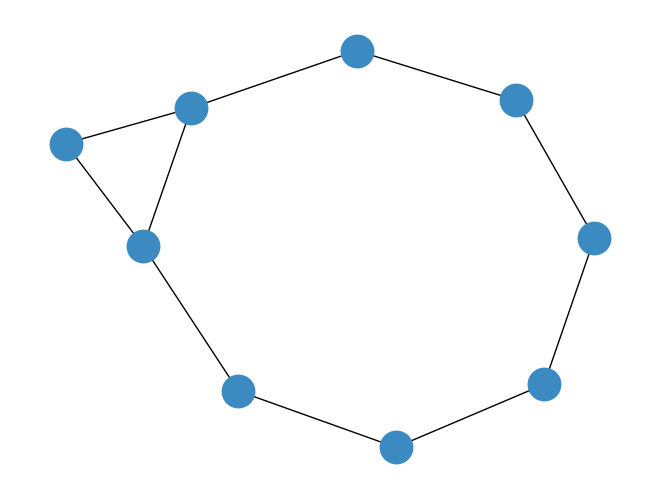

Graph predicted label:  3
epoch:  0 ; loss:  42.918609619140625 ; mask density:  0.7082099914550781 ; pred:  tensor([0.0049, 0.0048, 0.0044, 0.0065, 0.0021, 0.0026, 0.0036, 0.0032, 0.0031,
        0.0028, 0.0040, 0.0028, 0.0021, 0.0032, 0.0025, 0.0025, 0.0036, 0.0023,
        0.0023, 0.0027, 0.0028, 0.0028, 0.0026, 0.0019, 0.0027, 0.0027, 0.0032,
        0.0037, 0.0027, 0.0030, 0.0033, 0.0025, 0.0022, 0.0029, 0.0030, 0.0028,
        0.0021, 0.0020, 0.0033, 0.0024, 0.0028, 0.0026, 0.0036, 0.0032, 0.0032,
        0.0026, 0.0022, 0.0025, 0.0024, 0.0022, 0.0027, 0.0035, 0.0028, 0.0030,
        0.0024, 0.0028, 0.0030, 0.0027, 0.0026, 0.0028, 0.0034, 0.0034, 0.0023,
        0.0025, 0.0030, 0.0023, 0.0029, 0.0032, 0.0038, 0.0028, 0.0031, 0.0029,
        0.0022, 0.0026, 0.0030, 0.0025, 0.0020, 0.0035, 0.0030, 0.0032, 0.0028,
        0.0023, 0.0024, 0.0033, 0.0028, 0.0021, 0.0021, 0.0032, 0.0027, 0.0030,
        0.0031, 0.0027, 0.0025, 0.0024, 0.0027, 0.0028, 0.0024, 0.0029, 0.0021,
        0.0

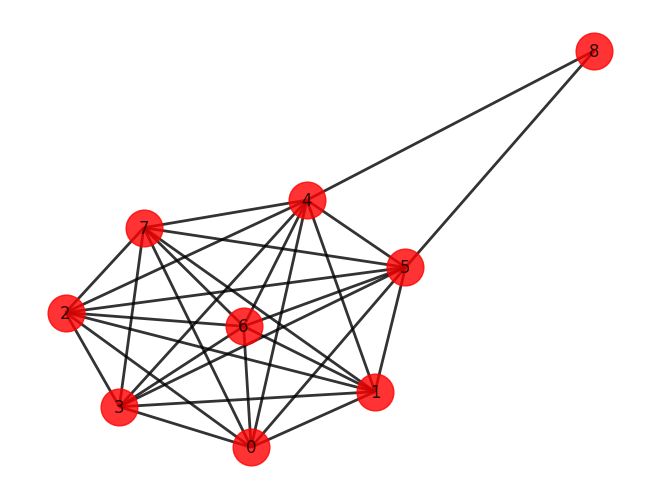

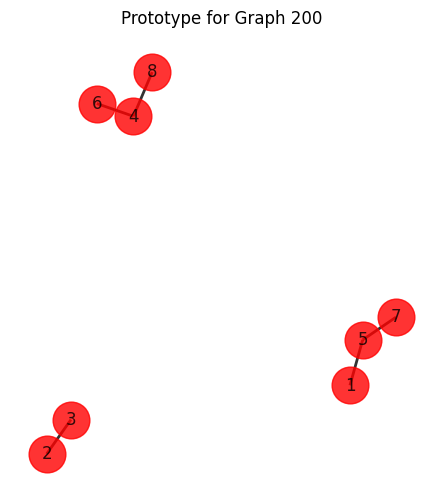

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

%matplotlib inline

# Function to plot the original and denoised (prototype) graph
def explain_and_plot_graph(graph_idx, data, threshold=0.9):
    """
    Explain a graph and visualize both the original graph and its prototype (important subgraph).

    Args:
    - graph_idx: Index of the graph to explain.
    - explainer: The explainer instance.
    - data: PyTorch Geometric Data object containing the graph.
    - threshold: Threshold for denoising the graph (removing less important edges).
    """

    # Explain the graph and get the masked adjacency matrix
    res = explainer.explain_graphs(graph_indices=[graph_idx])

    masked_adj = res[0]

    print(len(res))

    # Convert the PyG data object to a NetworkX graph for visualization
    original_G = to_networkx(data, to_undirected=True)

    # Get positions for the layout of the original graph
    pos = nx.spring_layout(original_G)

    # Plot 1: Original Graph
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    # nx.draw(
    #     original_G,
    #     pos,
    #     with_labels=True,
    #     node_color="red",
    #     edge_color="black",
    #     width=2,
    #     node_size=700,
    #     alpha=0.8,
    # )
    plt.title(f"Original Graph {graph_idx}")

    # Plot 2: Denoised Prototype (Using denoise_graph)

    # Use the denoise_graph function to filter important edges/nodes
    prototype_G = io_utils.denoise_graph(
        masked_adj,
        node_idx=0,  # Index of the central node
        feat=explainer.feat[graph_idx],
        threshold=threshold,  # Control how strict the filtering is
        max_component=False,
    )

    # Draw the prototype graph
    nx.draw(
        prototype_G,
        with_labels=True,
        node_color="red",
        edge_color="black",
        width=2,
        node_size=700,
        alpha=0.8,
    )
    plt.title(f"Prototype for Graph {graph_idx}")

    # Show both plots
    plt.show()


# Example usage
graph_idx = 200
data = pyg_dataset[graph_idx]
plot_graph(data)
explain_and_plot_graph(graph_idx, data, 0.75)